In [1]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt


In [2]:



def create_masks(adjacency_matrix, neurons_per_layer):
    num_layers = len(neurons_per_layer)
    num_nodes = adjacency_matrix.shape[0]
    layer_masks = []

    # Create masks for each layer based on the adjacency matrix and the idea of preserving the diagonal after the first layer.
    for layer_index in range(1, num_layers):
        prev_layer_size = neurons_per_layer[layer_index - 1]
        curr_layer_size = neurons_per_layer[layer_index]
        mask = np.zeros((curr_layer_size, prev_layer_size))

        # Process each node according to the adjacency matrix for the first layer
        if layer_index == 1:
            for i in range(num_nodes):
                for j in range(num_nodes):
                    if adjacency_matrix[i, j] == 1:
                        mask[j, i] = 1  # Allow signal as per adjacency matrix
        else:
            # After the first layer, maintain diagonal connectivity to ensure signal preservation
            # and also allow propagation according to the adjacency matrix logic
            np.fill_diagonal(mask, 1)  # Ensure self-preservation
            for i in range(min(num_nodes, prev_layer_size)):  # Keep within the smaller dimension
                for j in range(num_nodes):
                    if adjacency_matrix[i, j] == 1:
                        mask[j, i] = 1  # Propagate based on adjacency rules

        layer_masks.append(mask)

    return layer_masks


class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)
    
    

class MaskedLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super(MaskedLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.bias = nn.Parameter(torch.zeros(out_features))
        self.mask = None
        self.reset_parameters()
    
    def set_mask(self, mask):
        if isinstance(mask, np.ndarray):
            # Convert from NumPy array to Tensor and set the correct dtype
            mask_tensor = torch.from_numpy(mask).to(torch.float64)
        elif isinstance(mask, torch.Tensor):
            # Ensure the tensor is the correct dtype
            mask_tensor = mask.to(torch.float64)
        else:
            raise TypeError("Mask must be a NumPy array or a PyTorch tensor.")

        self.mask = nn.Parameter(mask_tensor, requires_grad=False)
    
    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=np.sqrt(5))
#         self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.01)
    
    def forward(self, input):
        if self.mask is not None:
            return nn.functional.linear(input, self.weight * self.mask)
        else:
            return nn.functional.linear(input, self.weight)
    
    
class DAGAutoencoder(nn.Module):
    def __init__(self, neurons_per_layer):
        super(DAGAutoencoder, self).__init__()
        self.layers = nn.ModuleList() 
        self.activations = nn.ModuleList()  

        for i in range(len(neurons_per_layer) - 1):
            linear_layer = MaskedLinear(neurons_per_layer[i], neurons_per_layer[i+1])
            self.layers.append(linear_layer)
            if i < len(neurons_per_layer) - 2:  
                self.activations.append(Swish())

    def set_masks(self, masks):
        # Apply masks only to linear layers
        assert len(masks) == len(self.layers), "The number of masks must match the number of linear layers."
        for layer, mask in zip(self.layers, masks):
            layer.set_mask(mask)
                
    def forward(self, x):
        for linear, activation in zip(self.layers, self.activations):
            x = linear(x)
            x = activation(x)
        x = self.layers[-1](x)  # Apply the last linear layer (without ReLU if it's the output layer)
        return x



In [3]:
def check_preds():
    # Extract all data for plotting
    model.eval()  # Ensure the model is in evaluation mode
    all_inputs = dataset[:][0]
    with torch.no_grad():
        all_predictions = model(all_inputs).numpy()

    # Actual data is the same as input in the autoencoder setup
    actual_data = all_inputs.numpy()

    # Variables are assumed to be in columns: A, B, C, D
    variables = ['A', 'B', 'C', 'D']

    # Create scatter plots
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
    axes = axes.ravel()  # Flatten the axis array

    for i, ax in enumerate(axes):
        ax.scatter(actual_data[:, i], all_predictions[:, i], alpha=0.5)
        ax.set_title(f'Predicted vs Actual for {variables[i]}')
        ax.set_xlabel('Actual Values')
        ax.set_ylabel('Predicted Values')
        ax.plot([actual_data[:, i].min(), actual_data[:, i].max()], 
                [actual_data[:, i].min(), actual_data[:, i].max()], 'k--')  # Diagonal line

    plt.tight_layout()
    plt.show()
    

torch.Size([500, 4])


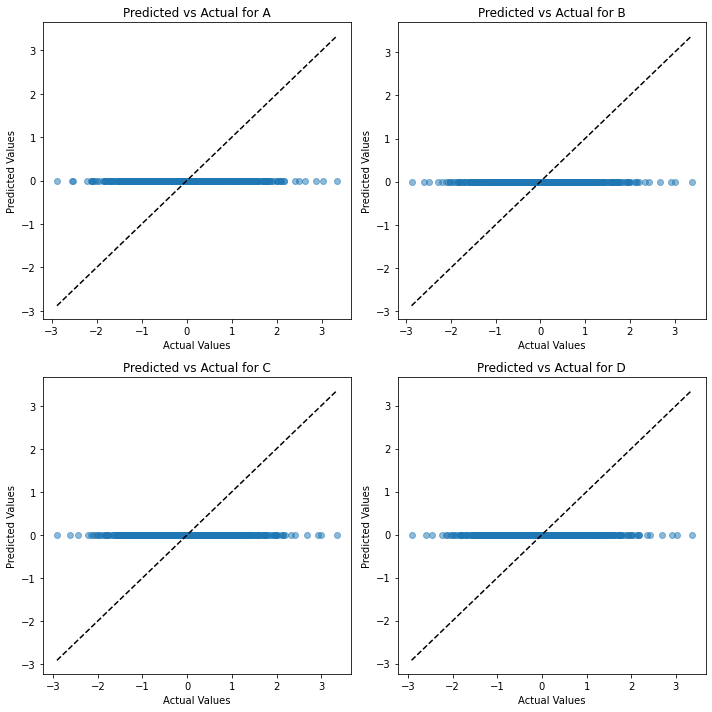

Epoch 10, Loss: 0.9999121873046231


KeyboardInterrupt: 

In [7]:
num_samples = 500  # Number of synthetic data samples
batch_size = 10  # Batch size for training
epochs = 5000  # Number of epochs for training

A = np.random.randn(num_samples)
B = 2 * A + 0.1 * np.random.randn(num_samples)
C = 2 * B + 0.1 * np.random.randn(num_samples)
D = 2 * A + 2 * C + 0.1 * np.random.randn(num_samples)
raw_data = np.column_stack((A, B, C, D))

# Standardize the data
mean = raw_data.mean(axis=0)
std = raw_data.std(axis=0)
data = (raw_data - mean) / std
data = torch.from_numpy(data).to(torch.float64)


input_size = data.shape[1]  
neurons_per_layer = [input_size,  8, 8, 8, 8, input_size]  

print(data.shape)

dataset = TensorDataset(data, data)  # Using the same data as both input and target
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


model = DAGAutoencoder(neurons_per_layer)

initial_adj_matrix = np.array([
    [0, 1, 0, 1],
    [0, 0, 1, 0],
    [0, 0, 0, 1],
    [0, 0, 0, 0]
])
initial_masks = [torch.from_numpy(mask).float().to(torch.float64) for mask in create_masks(initial_adj_matrix, neurons_per_layer)]
model.set_masks(initial_masks)


# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
for epoch in range(epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    for inputs, targets in dataloader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)  # Multiply by batch size

    # Print statistics
    epoch_loss = running_loss / num_samples
    if epoch % 100 == 9:
        check_preds()
        print(f'Epoch {epoch + 1}, Loss: {epoch_loss}')

print('Finished Training')

# Test the model with one example
test_input = torch.randn(1, input_size).to(torch.float64)
model.eval()  # Set model to evaluation mode
test_output = model(test_input)
print("Test input:", test_input)
print("Reconstructed output:", test_output)



In [8]:
initial_masks

[tensor([[0., 0., 0., 0.],
         [1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [1., 0., 1., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]], dtype=torch.float64),
 tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 1., 1., 0., 0., 0., 0., 0.],
         [1., 0., 1., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1.]], dtype=torch.float64),
 tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 0., 0., 0., 0., 0., 0.],
         [0., 1., 1., 0., 0., 0., 0., 0.],
         [1., 0., 1., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1.]], dtype=torch.float64),
 tensor([[1., 0., 0., 0., 0

In [ ]:
intervention_adj_matrix = np.zeros_like(initial_adj_matrix) 
intervention_masks = [torch.from_numpy(mask).float() for mask in create_masks(intervention_adj_matrix, neurons_per_layer)]
model.set_masks(intervention_masks)

# Example usage after intervention
output_after_intervention = model(test_input)
print("Output of the network after intervention:", output_after_intervention)

In [50]:
input_tensor = torch.ones((1, 4)).to(torch.float64)
o = torch.mm(input_tensor, (model.layers[0].weight * model.layers[0].mask).T)  
print('output:', o, 'mask used:', model.layers[0].mask)
o = torch.mm(o, (model.layers[1].weight * model.layers[1].mask).T)  
print('output:',o,'mask used:',  model.layers[1].mask)
o = torch.mm(o, (model.layers[2].weight * model.layers[2].mask).T) 
print('output:', o, 'mask used:', model.layers[2].mask)
o = torch.mm(o, (model.layers[3].weight * model.layers[3].mask).T) 
print('output:',o, 'mask used:', model.layers[3].mask)

output: tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], dtype=torch.float64, grad_fn=<MmBackward0>) mask used: Parameter containing:
tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0

In [6]:
initial_masks

[tensor([[0., 0., 0., 0.],
         [1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [1., 0., 1., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]], dtype=torch.float64),
 tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0.

In [101]:


def create_scaled_masks(adjacency_matrix, neurons_per_layer):
    num_layers = len(neurons_per_layer)
    num_nodes = adjacency_matrix.shape[0]
    layer_masks = []

    for layer_index in range(1, num_layers):
        prev_layer_size = neurons_per_layer[layer_index - 1]
        curr_layer_size = neurons_per_layer[layer_index]
        mask = np.zeros((curr_layer_size, prev_layer_size))

        if layer_index == 1:
            # Apply the adjacency matrix to the first layer scaled to the layer sizes
            for i in range(num_nodes):
                for j in range(num_nodes):
                    if adjacency_matrix[i, j]:
                        start_row = (curr_layer_size // num_nodes) * j
                        end_row = (curr_layer_size // num_nodes) * (j + 1)
                        start_col = (prev_layer_size // num_nodes) * i
                        end_col = (prev_layer_size // num_nodes) * (i + 1)
                        mask[start_row:end_row, start_col:end_col] = 1
        else:
            # Propagate connectivity using a scaled method
            ratio = prev_layer_size / curr_layer_size
            for i in range(prev_layer_size):
                if i < curr_layer_size:  # Check if index is within the bounds
                    scaled_col_start = int(np.floor(i * ratio))
                    scaled_col_end = int(np.ceil((i + 1) * ratio))
                    mask[i, scaled_col_start:scaled_col_end] = 1
                else:  # Ensure diagonal connectivity if previous layer was larger
                    np.fill_diagonal(mask, 1)

        layer_masks.append(mask)

    return layer_masks


# Example usage:
adjacency_matrix = np.array([[0, 1], [0, 0]])
neurons_per_layer = [2, 4, 8, 16, 8, 4, 2]  # Example: input, hidden, output layers
masks = create_scaled_masks(adjacency_matrix, neurons_per_layer)

weight1 = torch.ones(4,2).to(torch.float64)
weight2 = torch.ones(8,4).to(torch.float64)
weight3 = torch.ones(16,8).to(torch.float64)
weight4 = torch.ones(8,16).to(torch.float64)
weight5 = torch.ones(4,8).to(torch.float64)
weight6 = torch.ones(2,4).to(torch.float64)

input_tensor = torch.tensor([[3, 2]]).to(torch.float64)

o1 = torch.mm(input_tensor, (weight1*torch.tensor(masks[0])).T)  
print(o1)
o2 = torch.mm(o1, (weight2*torch.tensor(masks[1])).T) 
print(o2)
o3 = torch.mm(o2, (weight3*torch.tensor(masks[2])).T) 
print(o3)
o4 = torch.mm(o3, (weight4*torch.tensor(masks[3])).T) 
print(o4)
o5 = torch.mm(o4, (weight5*torch.tensor(masks[4])).T) 
print(o4)
o6 = torch.mm(o5, (weight6*torch.tensor(masks[5])).T) 
print(o6)

tensor([[0., 0., 3., 3.]], dtype=torch.float64)
tensor([[0., 0., 0., 0., 0., 0., 0., 0.]], dtype=torch.float64)
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       dtype=torch.float64)
tensor([[0., 0., 0., 0., 0., 0., 0., 0.]], dtype=torch.float64)
tensor([[0., 0., 0., 0., 0., 0., 0., 0.]], dtype=torch.float64)
tensor([[0., 0.]], dtype=torch.float64)


In [142]:
def create_mask_for_autoencoder(adjacency_matrix, neurons_per_layer):
    num_layers = len(neurons_per_layer)
    masks = []

    for layer_index in range(num_layers):
        num_nodes = neurons_per_layer[layer_index]
        mask = np.zeros((num_nodes, num_nodes), dtype=np.float64)

        # Fill the mask according to the adjacency matrix
        for i in range(num_nodes):
            for j in range(num_nodes):
                if i < adjacency_matrix.shape[0] and j < adjacency_matrix.shape[1]:
                    mask[j, i] = adjacency_matrix[i, j]

        masks.append(mask)

        # Add identity diagonal after the first layer
        if layer_index > 0:
            np.fill_diagonal(mask, 1)

            # Update the mask for expanded layer size
            prev_mask = masks[layer_index - 1]
            prev_layer_size = prev_mask.shape[0]
            curr_layer_size = mask.shape[0]
            row_scale = curr_layer_size // prev_layer_size
            col_scale = curr_layer_size // prev_layer_size

            if row_scale > 1 or col_scale > 1:
                # Repeat or tile the adjacency pattern to fit the expanded layer size
                expanded_adjacency = np.tile(adjacency_matrix, (row_scale, col_scale))
                mask[:prev_layer_size, :prev_layer_size] = expanded_adjacency[:prev_layer_size, :prev_layer_size]

    return masks

# Test the function
input_tensor = torch.tensor([[3, 2]], dtype=torch.float64)

# Adjacency matrix
adjacency_matrix = np.array([[0, 1], [0, 0]])

# Number of neurons per layer
neurons_per_layer = [2, 4]

# Weights for the first layer
weight1 = torch.ones(2, 2, dtype=torch.float64)
# Weights for the second layer
weight2 = torch.ones(4, 2, dtype=torch.float64)

# Create masks from the adjacency matrix and number of neurons per layer
masks = create_mask_for_autoencoder(adjacency_matrix, neurons_per_layer)

# Apply the masks to the weights
masked_weights1 = torch.tensor(masks[0]) * weight1
masked_weights2 = torch.tensor(masks[1]) * weight2[:neurons_per_layer[1], :]

# Print the masked weights
print("Masked weights for the first layer:")
print(masked_weights1)
print()
print("Masked weights for the second layer:")
print(masked_weights2)

RuntimeError: The size of tensor a (4) must match the size of tensor b (2) at non-singleton dimension 1

tensor([[3., 2.]], dtype=torch.float64)

In [172]:
input_tensor = torch.tensor([[1,3]], dtype=torch.float64)
print(input_tensor)
mask = torch.tensor(adjacency_matrix)
print(mask)
weight1 = torch.ones(2, 2, dtype=torch.float64)
print(weight1)
o1 = torch.mm(input_tensor, (weight1*mask).T) 
print(o1)

tensor([[1., 3.]], dtype=torch.float64)
tensor([[0, 1],
        [0, 0]])
tensor([[1., 1.],
        [1., 1.]], dtype=torch.float64)
tensor([[3., 0.]], dtype=torch.float64)


In [372]:
def expand_matrix(original_matrix, target_shape):
    original_rows, original_columns = original_matrix.shape
    target_rows, target_columns = target_shape
    
    # Calculate the number of times to repeat each row and column
    row_repeats = target_rows // original_rows
    column_repeats = target_columns // original_columns
    
    # Repeat rows and columns to expand the matrix
    expanded_matrix = np.repeat(np.repeat(original_matrix, row_repeats, axis=0), column_repeats, axis=1)
    
    return expanded_matrix

def calculate_weight_shape(initial_shape, target_shape):
    initial_rows, initial_columns = initial_shape
    target_rows, target_columns = target_shape
    
    # Calculate the number of rows and columns in the weight matrices
    weight_rows = target_columns
    weight_columns = initial_columns
    
    return (weight_rows, weight_columns)



In [373]:

def expand_adjacency_matrix(neurons_per_layer, adjacency_matrix):
    # Calculate target shapes for each layer based on the number of neurons
    target_shapes = [(1, neurons) for neurons in neurons_per_layer]
    
    # Initialize the expanded adjacency matrix list
    expanded_matrices = []
    
    # Iterate through each layer and expand the adjacency matrix
    for i, target_shape in enumerate(target_shapes):
        # Calculate the weight shape for the current layer
        weight_shape = calculate_weight_shape(adjacency_matrix.shape, target_shape)
        
        # Expand the adjacency matrix to match the weight shape
        expanded_matrix = expand_matrix(adjacency_matrix, weight_shape)
        
        # Append the expanded matrix to the list
        expanded_matrices.append(expanded_matrix)
    
    return expanded_matrices

# Example usage:
neurons_per_layer = [2, 4, 8, 4, 2]
adjacency_matrix = np.array([[0, 1], [0, 0]])

expanded_matrices = expand_adjacency_matrix(neurons_per_layer, adjacency_matrix)
for i, matrix in enumerate(expanded_matrices):
    print(f"Layer {i+1} adjacency matrix:")
    print(matrix)
    print()

Layer 1 adjacency matrix:
[[0 1]
 [0 0]]

Layer 2 adjacency matrix:
[[0 1]
 [0 1]
 [0 0]
 [0 0]]

Layer 3 adjacency matrix:
[[0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]]

Layer 4 adjacency matrix:
[[0 1]
 [0 1]
 [0 0]
 [0 0]]

Layer 5 adjacency matrix:
[[0 1]
 [0 0]]



In [ ]:
# TODO: create a function which adds 'diagonal elements' in arbitrarily shaped matrices.

Expanded matrix to 6x6:
[[1 1 0 0 1 1]
 [0 0 1 1 0 0]
 [0 0 0 0 1 1]]
